In [1]:
# 导入第三方基本库
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [2]:
# 导入数据(训练集)
data = pd.read_csv('/Users/fangcheng/sklearn/Detect_AI_Generated_Text/llm-detect-ai-generated-text/train_prompts.csv')
data.head()

,prompt_id,prompt_name,instructions,source_text
0,0,Car-free cities,Write an explanatory essay to inform fellow ci...,"# In German Suburb, Life Goes On Without Cars ..."
1,1,Does the electoral college work?,Write a letter to your state senator in which ...,# What Is the Electoral College? by the Office...


In [3]:
# 导入数据(测试集)
data_test = pd.read_csv('/Users/fangcheng/sklearn/Detect_AI_Generated_Text/llm-detect-ai-generated-text/test_essays.csv')
data_test.head()

,id,prompt_id,text
0,0000aaaa,2,Aaa bbb ccc.
1,1111bbbb,3,Bbb ccc ddd.
2,2222cccc,4,CCC ddd eee.


In [4]:
# 导入sklearn

import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier, DummyRegressor
from scikitplot.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report, f1_score, recall_score, precision_score, accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [5]:
# 导入外部数据并对外部数据做出处理
external_date = pd.read_csv("/Users/fangcheng/sklearn/Detect_AI_Generated_Text/llm-detect-ai-generated-text/daigt_external_dataset.csv", sep=',')
print(external_date.shape)
external_date = external_date.rename(columns={'generated': 'label'})
external_date = external_date[["source_text"]]
external_date.columns = ["text"]
external_date['text'] = external_date['text'].str.replace('\n', '')
external_date["label"] = 1

(2421, 4)


In [6]:
train = pd.read_csv("/Users/fangcheng/sklearn/Detect_AI_Generated_Text/llm-detect-ai-generated-text/archive/train_essays_RDizzl3_seven_v1.csv")
train=pd.concat([train,external_date])
test = pd.read_csv('/Users/fangcheng/sklearn/Detect_AI_Generated_Text/llm-detect-ai-generated-text/test_essays.csv')

df=pd.concat([train,external_date])

vectorizer = TfidfVectorizer(ngram_range=(1, 3),sublinear_tf=True)
X = vectorizer.fit_transform(df)

In [7]:
models = [
        ('svm', SVC(probability = True)),
        ('sgd', SGDClassifier(loss ='log_loss')),
        ('decision tree', DecisionTreeClassifier(max_depth=7)),
        ('random forest', RandomForestClassifier(n_estimators=250, max_depth=7, random_state=0)),
        ('xgboost', xgb.XGBClassifier(n_estimators=250, max_depth=5, random_state=0)),
    ]

def run_models(X, y, scoring = 'binary'):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 2000)
    
    num_cols = 4
    fig, axes = plt.subplots(nrows=2, ncols=num_cols, figsize=(20,10))
    metrics = {}
    for it, (model_name, model) in enumerate(models):
    
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)
        f1 = f1_score(y_test, y_pred, average = scoring).round(3)
        AUC = roc_auc_score(y_test, y_pred_proba[:, 1]).round(3)
        print(f"F1 Score {model_name}: {f1}. AUC: {AUC}")
        metrics[model_name] = AUC
        
        ax = axes[it // num_cols, it % num_cols]
        plot_confusion_matrix(y_test, y_pred, ax=ax, title=f"model: {model_name}")
    return metrics

In [8]:
df['len'] = df['text'].str.len()
df['question'] = df['text'].map(lambda text: 1 if "?" in text else 0)
df['exclamation'] = df['text'].map(lambda text: 1 if "!" in text else 0)
df['n_word'] = df['text'].map(lambda x: len(x.split()))

In [9]:
X = df[['n_word','question','exclamation','len']]
y = df['label']
y.value_counts()

0    14250
1     6463
Name: label, dtype: int64

F1 Score svm: 0.815. AUC: 0.952
F1 Score sgd: 0.838. AUC: 0.889
F1 Score decision tree: 0.743. AUC: 0.903
F1 Score random forest: 0.786. AUC: 0.926
F1 Score xgboost: 0.879. AUC: 0.971


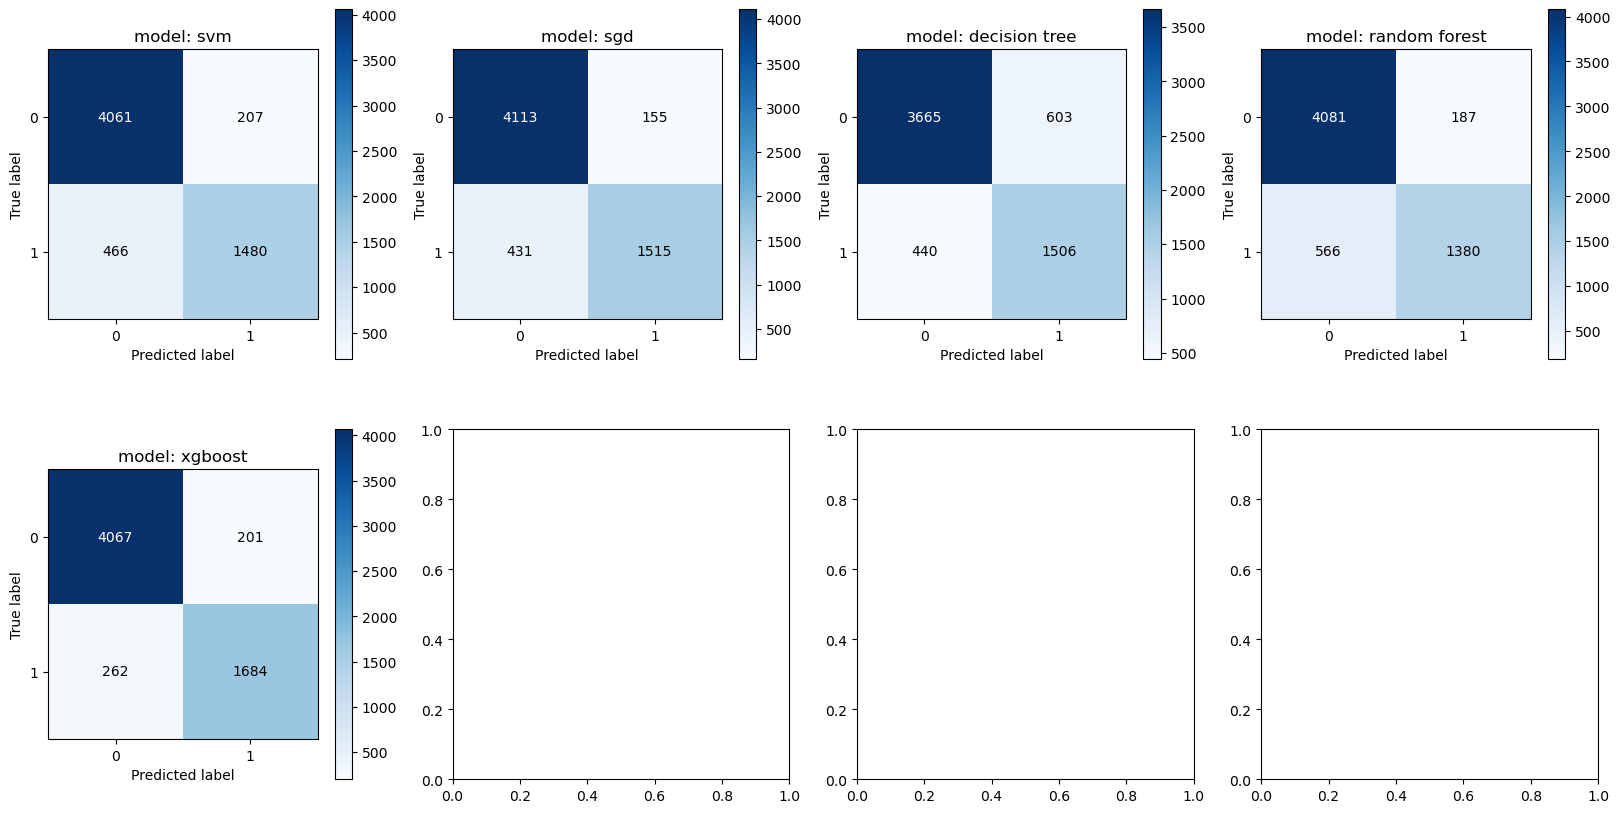

In [10]:
# 即使在基模型上，AUC也相当高!
meta_features = run_models(X, y)

In [11]:
 df = pd.concat([train['text'], test['text']], axis=0)

In [12]:
vectorizer = CountVectorizer(ngram_range=(1,3 ), dtype=np.float32)
X = vectorizer.fit_transform(df)

In [13]:
ensemble = VotingClassifier(estimators=models, voting='soft')
ensemble.fit(X[:train.shape[0]], train.label)

VotingClassifier(estimators=[('svm', SVC(probability=True)),
                             ('sgd', SGDClassifier(loss='log_loss')),
                             ('decision tree',
                              DecisionTreeClassifier(max_depth=7)),
                             ('random forest',
                              RandomForestClassifier(max_depth=7,
                                                     n_estimators=250,
                                                     random_state=0)),
                             ('xgboost',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,...
                                            gpu_id=None, grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=5,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=250, n_jobs=None,
                                            num_parallel_tree=None,
                                            predictor=None, random_state=0, ...))],
                 voting='soft')

In [14]:
preds_test = ensemble.predict_proba(X[train.shape[0]:])[:,1]

In [15]:
pd.DataFrame({'id':test["id"],'generated':preds_test}).to_csv('/Users/fangcheng/sklearn/Detect_AI_Generated_Text/llm-detect-ai-generated-text/submission.csv', index=False)